In [0]:
%restart_python

In [0]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .remote("")   # remove Spark Connect remote
         .getOrCreate())

In [0]:
import pandas as pd

In [0]:
df_features = spark.read.table("workspace.default.features")
df_train = spark.read.table("workspace.default.train")
df_stores = spark.read.table("workspace.default.stores")
df_partial = df_train.join(df_features, on=["Store", "Date", "IsHoliday"], how="left")
df = df_partial.join(df_stores, on="Store", how="left") 
df.show(5)

+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type|  Size|
+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|    1|2010-02-05|    false|   1|     24924.5|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|   A|151315|
|    1|2010-02-12|     true|   1|    46039.49|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|   A|151315|
|    1|2010-02-19|    false|   1|    41595.55|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|   A|151315|
|    1|2010-02-26|    false|   1|    19403.54|      46.63|

In [0]:
df.printSchema()
df.count()

root
 |-- Store: long (nullable = true)
 |-- Date: date (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Dept: long (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: long (nullable = true)



421570

In [0]:
bronze_df_new_full = spark.read.table("workspace.default.Full_df")
bronze_df_new_full.show(5)

+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type|  Size|
+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|    1|2010-02-05|    false|   1|     24924.5|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|   A|151315|
|    1|2010-02-12|     true|   1|    46039.49|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|   A|151315|
|    1|2010-02-19|    false|   1|    41595.55|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|   A|151315|
|    1|2010-02-26|    false|   1|    19403.54|      46.63|

In [0]:
from pyspark.sql.functions import col,sum,when

In [0]:
null_counts = bronze_df_new_full.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in bronze_df_new_full.columns
])
null_counts.show()

+-----+----+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+---+------------+----+----+
|Store|Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|Type|Size|
+-----+----+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+---+------------+----+----+
|    0|   0|        0|   0|           0|          0|         0|        0|        0|        0|        0|        0|  0|           0|   0|   0|
+-----+----+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+---+------------+----+----+



In [0]:
from pyspark.sql.types import StringType

null_counts = bronze_df_new_full.select([
    sum(
        (
            col(c).isNull() if not isinstance(bronze_df_new_full.schema[c].dataType, StringType)
            else (col(c).isNull() | col(c).isin(['NA', '']))
        ).cast("int")
    ).alias(c)
    for c in bronze_df_new_full.columns])
display(null_counts)

Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,0,0,0,0,0,270889,310322,284479,286603,270138,0,0,0,0


In [0]:
problem_cols = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",
                "CPI","Unemployment"]

In [0]:
for c in problem_cols:
    bronze_df = bronze_df_new_full.withColumn(c, when(col(c) == "NA", None).otherwise(col(c)))

In [0]:
from pyspark.sql.functions import lower
silver_df_new_full = (bronze_df_new_full
             .withColumn("Store", col("Store").cast("int"))
             .withColumn("Dept", col("Dept").cast("int"))
             .withColumn("Date", col("Date").cast("date"))
             .withColumn("Weekly_Sales", col("Weekly_Sales").cast("double"))
             .withColumn("Temperature", col("Temperature").cast("double"))
             .withColumn("Fuel_Price", col("Fuel_Price").cast("double"))
             .withColumn("CPI", col("CPI").cast("double"))
             .withColumn("Unemployment", col("Unemployment").cast("double"))
             .withColumn("IsHoliday", lower(col("IsHoliday")).cast("boolean"))
            )

In [0]:
silver_df_new_full = silver_df_new_full.fillna({c: 0 for c in ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]})

In [0]:
silver_df_new_full.show(20)

+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type|  Size|
+-----+----------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|    1|2010-02-05|    false|   1|     24924.5|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|   A|151315|
|    1|2010-02-12|     true|   1|    46039.49|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|   A|151315|
|    1|2010-02-19|    false|   1|    41595.55|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|   A|151315|
|    1|2010-02-26|    false|   1|    19403.54|      46.63|

In [0]:
silver_df_new_full.columns

['Store',
 'Date',
 'IsHoliday',
 'Dept',
 'Weekly_Sales',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Type',
 'Size']

In [0]:
spark


In [0]:
pandas_df = df.sample(fraction=0.05, seed=42).toPandas()
print(pandas_df.shape)
pandas_df.head()

(21002, 16)


,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-03-05,False,1,21827.90,46.50,2.625,NA,NA,NA,NA,NA,211.3501429,8.106,A,151315
1,1,2011-01-28,False,1,18461.18,43.83,3.010,NA,NA,NA,NA,NA,212.1970577,7.742,A,151315
2,1,2011-03-11,False,1,21280.40,53.56,3.459,NA,NA,NA,NA,NA,214.1110564,7.742,A,151315
3,1,2011-06-03,False,1,16434.15,83.00,3.699,NA,NA,NA,NA,NA,215.2736553,7.682,A,151315
4,1,2012-06-15,False,1,17558.82,79.35,3.393,5621.99,109.6,0.25,2420.28,3083.26,221.7626421,7.143,A,151315


In [0]:
import numpy as np

# Replace "NA" with np.nan
pandas_df.replace("NA", np.nan, inplace=True)

# Fill missing numeric values with 0 (or median if you prefer)
for col in ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","CPI","Unemployment"]:
    pandas_df[col] = pd.to_numeric(pandas_df[col], errors="coerce").fillna(0)

# Ensure correct dtypes
pandas_df["IsHoliday"] = pandas_df["IsHoliday"].astype(int)  # 0/1
pandas_df["Weekly_Sales"] = pd.to_numeric(pandas_df["Weekly_Sales"], errors="coerce")


In [0]:
# Extract date features
pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])
pandas_df["Year"] = pandas_df["Date"].dt.year
pandas_df["Month"] = pandas_df["Date"].dt.month
pandas_df["WeekOfYear"] = pandas_df["Date"].dt.isocalendar().week
pandas_df["DayOfWeek"] = pandas_df["Date"].dt.dayofweek


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features & target
target = "Weekly_Sales"
features = ["Temperature","Fuel_Price","CPI","Unemployment",
            "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",
            "Size","IsHoliday","Type","Year","Month","WeekOfYear","DayOfWeek"]

X = pandas_df[features]
y = pandas_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ["Temperature","Fuel_Price","CPI","Unemployment",
                    "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",
                    "Size","Year","Month","WeekOfYear","DayOfWeek"]

categorical_features = ["Type","IsHoliday"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff268ecab560>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ML pipeline
model = Pipeline(steps=[("preprocessor", preprocessor),
                       ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))])

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))


RMSE: 24529.29414511083
R²: -0.24882063821851808


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [0]:
%pip install xgboost
%pip install prophet
%pip install tensorflow


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Use the same preprocessor from before
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 22430.887099488715
XGBoost R²: -0.044294195294415584


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing


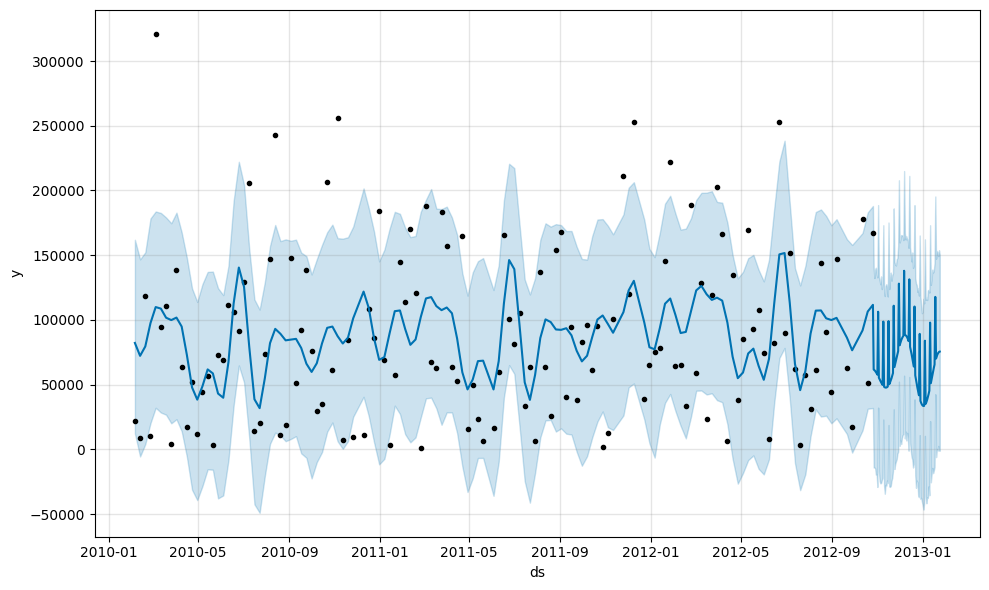

In [0]:
from prophet import Prophet

# Filter one store
store_df = pandas_df[pandas_df["Store"] == 1][["Date", "Weekly_Sales"]].copy()
store_df = store_df.groupby("Date", as_index=False).sum()  # aggregate by date
store_df.columns = ["ds", "y"]  # Prophet requires these names

# Train Prophet
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet.fit(store_df)

# Forecast next 90 days
future = prophet.make_future_dataframe(periods=90, freq="D")
forecast = prophet.predict(future)

# Plot
fig = prophet.plot(forecast)


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Example: one store’s weekly sales
store_df = pandas_df[pandas_df["Store"] == 1][["Date","Weekly_Sales"]].copy()
store_df = store_df.groupby("Date", as_index=False).sum()

# Scale sales
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(store_df[["Weekly_Sales"]])

# Create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(sales_scaled, SEQ_LEN)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM
model = Sequential([
    LSTM(64, activation="relu", input_shape=(SEQ_LEN, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

print("Sample predictions:", y_pred_rescaled[:5].flatten())


Epoch 1/10


/local_disk0/.ephemeral_nfs/envs/pythonEnv-c556d512-2abf-46cc-9ee4-adc1b8d0e30f/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0980 - val_loss: 0.0776
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0699 - val_loss: 0.0498
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0491 - val_loss: 0.0366
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0446 - val_loss: 0.0375
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0439 - val_loss: 0.0366
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0430 - val_loss: 0.0364
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0421 - val_loss: 0.0363
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0422 - val_loss: 0.0363
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0422 - val_loss: 0.0361
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0425 - val_loss: 0.0360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Sample predictions: [90377.32 91934.15 93089.05 89814.66 91443.4 ]


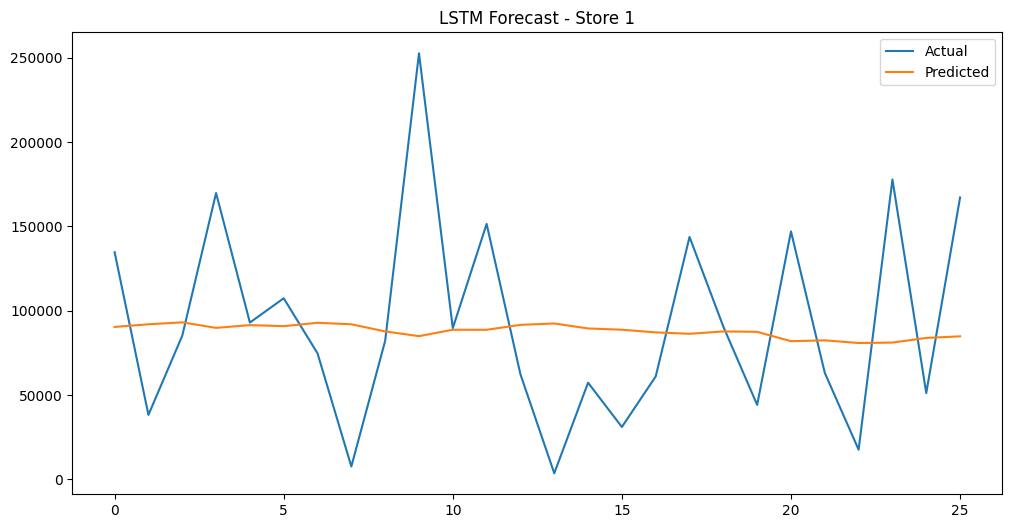

In [0]:
import matplotlib.pyplot as plt

# Rescale actual values
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.legend()
plt.title("LSTM Forecast - Store 1")
plt.show()
